In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import sys
from sklearn.metrics import accuracy_score

In [2]:
source_folder = "C:\\Users\\18503\\Dropbox\\Course\\Applied Machine Learning\\Homework\\hw12"

In [3]:
os.listdir(os.path.join(source_folder,"satimage"))

['sat.doc', 'sat.trn', 'sat.tst', 'X.dat', 'Xtest.dat', 'Y.dat', 'Ytest.dat']

### PreProcessing

In [4]:
def Preprocess(dataset,delimiter):
    Train_data  = np.genfromtxt(os.path.join(source_folder,dataset,"X.dat"),delimiter =delimiter)
    Train_label = np.genfromtxt(os.path.join(source_folder,dataset,"Y.dat"))
    Test_data  = np.genfromtxt(os.path.join(source_folder,dataset,"Xtest.dat"),delimiter=delimiter)
    Test_label = np.genfromtxt(os.path.join(source_folder,dataset,"Ytest.dat"))
    scaler = preprocessing.StandardScaler().fit(Train_data)
    Train_data = scaler.transform(Train_data)
    Test_data  = scaler.transform(Test_data)
    return Train_data,Train_label.reshape(-1,1),Test_data,Test_label.reshape(-1,1)

In [5]:
def inverse_scheduler(k,N_iter,i,mu,M,X,Xtest,W):
    
    M_i = k + (M-k)*np.max((0,(N_iter-2*i)/(2*i*mu + N_iter)))
    M_i = int(M_i)
    Sum_W_column = np.sum(abs(W),axis = 1)
    Highest_sum =  np.argsort(Sum_W_column)
    Drop_col = Highest_sum[M_i:]
    X     = np.delete(X, Drop_col, 1)
    Xtest = np.delete(Xtest, Drop_col, 1)
    W     = np.delete(W, Drop_col, 0)
    
    return X,Xtest,W

In [6]:
def get_vapnik(data,label,Weight,Lambda=0.0001,lr=1e-2):
    X,Y,W = data.copy(),label.copy(),Weight.copy()
    N = len(Y)
    DlDw = np.zeros((W.shape))
    loss = 0
    #one training example at a time
    for index,x_i in enumerate(X): 
        #k=true class
        k = int(Y[index]) 
        prod = x_i@W
        positions = [y for y in range(6) if y!=k]
        temp = np.exp( -1*(prod[positions] - prod[k] ) )
        temp2 = temp/(1 + temp).reshape(1,-1)
        #the case where k!=y
        DlDw[:,positions] += -1*(x_i.reshape(-1,1)*temp2) 
        #the case where k==y
        DlDw[:,k] += (x_i*np.sum(temp2,axis=None)) 
        #Loss contributed by each x_i
        loss += np.sum([np.log(1+term) for term in temp],axis=None)
        
    DlDw += 2*Lambda*W #add the normalziation share
    DlDw = DlDw/N
    loss += Lambda*np.linalg.norm(W)**2 #add the normalziation share
    loss = loss/N
    return DlDw,loss

In [39]:
def get_cross_entropy(data,label,Weight,Lambda=0.0001,lr=1e-2):
    X,Y,W = data.copy(),label.copy(),Weight.copy()
    N = len(Y)
    DlDw = np.zeros((W.shape))
    loss = 0
    #one training example at a time
    for index,x_i in enumerate(X): 
        #k=true class
        k = int(Y[index]) 
        prod = x_i@W
        positions = [y for y in range(6) if y!=k]
        temp = np.exp( prod )
        temp2 = temp/(np.sum(temp,axis=None))
        #temp2 = temp2
        #the case where k!=y plus part of k==y
        DlDw += x_i.reshape(-1,1)*temp2
        #the other part of k==y
        DlDw[:,k] += -1*x_i 
        #print(temp2.shape,(x_i.reshape(-1,1)*temp2).shape,x_i.shape,DlDw[:,k].shape)
        #sys.exit()
        #Loss contributed by each x_i
        loss = loss + np.log(np.sum(temp,axis=None)) - x_i@W[:,k]
        
    DlDw += 2*Lambda*W #add the normalziation share
    DlDw = DlDw/N
    loss += Lambda*np.linalg.norm(W)**2 #add the normalziation share
    loss = loss/N
    return DlDw,loss

In [8]:
def get_accuracy(X,Y,Xtest,Ytest,W):
    Predictions_train = X@W
    Predictions_train = np.argmax(abs(Predictions_train), axis=1)
    Training_error = 1 - accuracy_score(Y,Predictions_train)
    print("Training Miclassification error is ", Training_error)
    
    Predictions_test = Xtest@W
    Predictions_test = np.argmax(abs(Predictions_test), axis=1) 
    Test_error = 1 - accuracy_score(Ytest,Predictions_test)
    print("Test Miclassification error is ", Test_error)
    
    return Training_error,Test_error

In [9]:
def run_main(k=36,lr=20,N_iter=500,loss_function='VAPNIK'):
    
    print("\n\n Routine Running for k = ", k )
    dataset  = str("satimage")
    Train_data,Train_label,Test_data,Test_label = Preprocess(dataset,delimiter="")
    #Train_data.shape,Train_label.shape,Test_data.shape,Test_label.shape

    N = len(Train_label)
    M,mu = 36,100
    loss = np.zeros((N_iter))

    W = np.zeros((36,6))

    for i in range(N_iter):
        DlDw = np.zeros((W.shape))
        if loss_function == 'VAPNIK':
            DlDw,loss[i] = get_vapnik(Train_data,Train_label,W,lr)
        else:
            DlDw,loss[i] = get_cross_entropy(Train_data,Train_label,W,lr)
        W = W -  (lr/N)*DlDw
        print(i,loss[i])
        Train_data,Test_data,W = inverse_scheduler(k,N_iter,i,mu,M,Train_data,Test_data,W)
        #print(W.shape,Train_data.shape)
    plt.plot(loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss for feature k = %s" %k)
    plt.show()
    Training_error,Test_error = get_accuracy(Train_data,Train_label,Test_data,Test_label,W)
    return Training_error,Test_error

## Part 1



 Routine Running for k =  5
0 3.465735902800106
1 3.161100233795963
2 3.050050930142324
3 2.9881085085613086
4 2.965628249424274
5 2.930427433927091
6 2.888123285286404
7 2.901287714997361
8 2.895054713397797
9 2.8429069186033686
10 2.8604246127767112
11 2.894378618098768
12 2.8601966803181096
13 2.828047271227804
14 2.8966532236369127
15 2.8740488792339245
16 2.8528334814920253
17 2.8883578013022255
18 2.8688753369875464
19 2.8504432392016676
20 2.832974613705256
21 2.816392158667775
22 2.80062686331958
23 2.851469901337851
24 2.8364369560374567
25 2.8220734066147863
26 2.808333429301499
27 2.7951754113714458
28 2.782561471222325
29 2.7704570425513144
30 2.7588305130613264
31 2.747652909655956
32 2.7368976233593583
33 2.800129278546294
34 2.7891590184284407
35 2.778574127671561
36 2.7683537376214296
37 2.758478504913336
38 2.7489304720667658
39 2.7396929431999517
40 2.730750372998775
41 2.722088267326541
42 2.7136930940771964
43 2.7055522030604147
44 2.6976537538653935
45 2.68998665

368 2.29639295061055
369 2.2961420252519695
370 2.295892573217272
371 2.2956445832937296
372 2.295398044377962
373 2.2951529454745976
374 2.294909275695014
375 2.2946670242559635
376 2.2944261804783594
377 2.294186733785982
378 2.293948673704274
379 2.293711989859065
380 2.2934766719754536
381 2.2932427098765444
382 2.2930100934823003
383 2.2927788128084234
384 2.292548857965197
385 2.2923202191563297
386 2.292092886677937
387 2.291866850917363
388 2.2916421023521822
389 2.2914186315491
390 2.291196429162964
391 2.2909754859356384
392 2.2907557926950886
393 2.290537340354355
394 2.2903201199105347
395 2.290104122443868
396 2.2898893391167356
397 2.2896757611727434
398 2.289463379935788
399 2.2892521868091196
400 2.2890421732744435
401 2.288833330891076
402 2.288625651294998
403 2.2884191261980207
404 2.288213747386897
405 2.288009506722566
406 2.287806396139211
407 2.2876044076434985
408 2.287403533313771
409 2.2872037652992088
410 2.2870050958190866
411 2.2868075171619577
412 2.286611

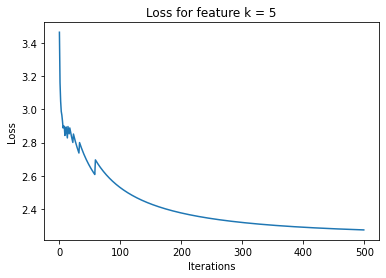

Training Miclassification error is  0.7648252536640361
Test Miclassification error is  0.7655000000000001


 Routine Running for k =  9
0 3.465735902800106
1 3.161100233795963
2 3.0356898827772483
3 2.9703556134675067
4 2.8927973673528364
5 2.8470873182570293
6 2.8186048994216786
7 2.783271033097806
8 2.753627806705505
9 2.692477311511204
10 2.689875666653784
11 2.6387113899026473
12 2.6561750998931637
13 2.612906191106497
14 2.572267795936446
15 2.6121717523203607
16 2.577306721252474
17 2.5442576862367363
18 2.5128752904852716
19 2.4830272844048267
20 2.5558003233639806
21 2.5302800072667195
22 2.5058524881046487
23 2.4824411503968227
24 2.4599769955322786
25 2.4383976593265673
26 2.4176465835096463
27 2.397672313256008
28 2.378427898496254
29 2.506190428169941
30 2.490389946061679
31 2.4751117440588493
32 2.4603258965228703
33 2.4460049235656203
34 2.4321235346687016
35 2.41865840476125
36 2.4055879779780516
37 2.3928922951149114
38 2.380552841448351
39 2.3685524121177495
40 2.35687

364 2.2061790691826686
365 2.2060365384862597
366 2.2058949665171768
367 2.2057543452030535
368 2.205614666554556
369 2.2054759226643723
370 2.2053381057061654
371 2.2052012079335963
372 2.2050652216793436
373 2.2049301393540666
374 2.204795953445531
375 2.2046626565176055
376 2.204530241209346
377 2.2043987002340883
378 2.2042680263785246
379 2.20413821250182
380 2.2040092515347616
381 2.203881136478821
382 2.2037538604053784
383 2.2036274164548306
384 2.20350179783579
385 2.203376997824261
386 2.2032530097628067
387 2.203129827059806
388 2.2030074431886093
389 2.2028858516868324
390 2.2027650461555357
391 2.2026450202585077
392 2.2025257677215246
393 2.2024072823315937
394 2.202289557936277
395 2.202172588442942
396 2.202056367818087
397 2.2019408900866178
398 2.2018261493312403
399 2.2017121396916877
400 2.201598855364165
401 2.2014862906005934
402 2.2013744397080526
403 2.2012632970481003
404 2.201152857036144
405 2.201043114140858
406 2.2009340628835417
407 2.2008256978375336
408 

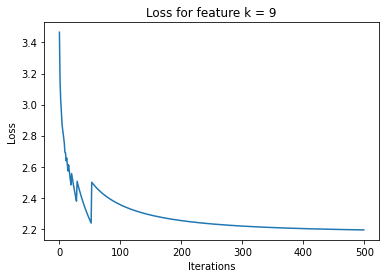

Training Miclassification error is  0.762119503945885
Test Miclassification error is  0.76


 Routine Running for k =  18
0 3.465735902800106
1 3.1970791483595775
2 3.0567926486284698
3 2.950090280220665
4 2.843794271146516
5 2.788761219092192
6 2.7246034407710478
7 2.6430951732631254
8 2.59831130332616
9 2.5313305359870117
10 2.502911496947481
11 2.4464016243060316
12 2.3941431148320613
13 2.3904047198766447
14 2.344535954373346
15 2.301645327640152
16 2.2614246195353727
17 2.2236082102326225
18 2.187965864491348
19 2.1542969391525366
20 2.166872373534693
21 2.1362262977883493
22 2.107128160601716
23 2.079451720720305
24 2.0530846373606146
25 2.027926574683766
26 2.0038876110608728
27 1.9808868971684876
28 1.9588515184122073
29 1.937715526067766
30 1.9174191084718872
31 1.897907879050115
32 1.879132262282063
33 1.8610469621343388
34 1.8436105002347276
35 1.8267848132678446
36 1.8105349008558722
37 1.7948285166379492
38 1.8370941928218318
39 1.8220101797267256
40 1.8074164008779443
41 

360 0.9542157888045669
361 0.9536370433978392
362 0.9530610417883006
363 0.9524877648511999
364 0.951917193641118
365 0.9513493093898322
366 0.9507840935042251
367 0.9502215275641969
368 0.9496615933206465
369 0.949104272693437
370 0.9485495477694387
371 0.9479974008005461
372 0.9474478142017757
373 0.9469007705493504
374 0.9463562525788345
375 0.945814243183292
376 0.9452747254114549
377 0.9447376824659336
378 0.9442030977014566
379 0.9436709546231146
380 0.9431412368846417
381 0.942613928286724
382 0.9420890127753218
383 0.9415664744400281
384 0.9410462975124353
385 0.9405284663645246
386 0.9400129655070956
387 0.9394997795881996
388 0.938988893391605
389 0.9384802918352707
390 0.9379739599698522
391 0.937469882977225
392 0.9369680461690293
393 0.9364684349852271
394 0.9359710349926851
395 0.935475831883783
396 0.9349828114750123
397 0.9344919597056432
398 0.934003262636351
399 0.9335167064479146
400 0.9330322774398924
401 0.9325499620293403
402 0.9320697467495253
403 0.9315916182486

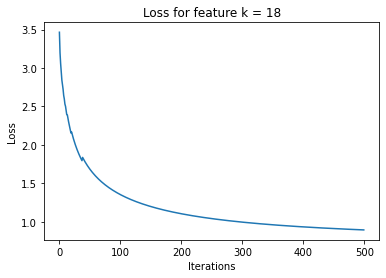

Training Miclassification error is  0.3645997745208568
Test Miclassification error is  0.39049999999999996


 Routine Running for k =  27
0 3.465735902800106
1 3.2708274273758793
2 3.133511002759422
3 3.024573984028695
4 2.9104250724969347
5 2.8282484533351284
6 2.7607651530094532
7 2.6813490154496753
8 2.609120009307947
9 2.5430936419855037
10 2.5108341797536404
11 2.455176969922567
12 2.4035543273281226
13 2.355504868727478
14 2.310636671865788
15 2.2686147075424414
16 2.229150848333915
17 2.19199588322513
18 2.1569330972648775
19 2.1237730772028534
20 2.131685090839853
21 2.101343138731207
22 2.072463766251641
23 2.044932515255976
24 2.018647147068138
25 1.9935160136507886
26 1.9694566859318752
27 1.9463947928974124
28 1.9242630343719618
29 1.903000337683245
30 1.8825511341225225
31 1.8628647356265873
32 1.8438947956937777
33 1.8255988414098552
34 1.8079378657587732
35 1.7908759712479994
36 1.7743800573824182
37 1.7584195457454699
38 1.7429661374495347
39 1.727993598541355
40 1.7134

359 0.8503597002910664
360 0.8497813879506972
361 0.8492058050922939
362 0.8486329322513243
363 0.8480627501506401
364 0.8474952396982112
365 0.8469303819848619
366 0.8463681582820829
367 0.845808550039843
368 0.8452515388844531
369 0.8446971066164299
370 0.8441452352084299
371 0.8435959068031937
372 0.8430491037115181
373 0.8425048084102543
374 0.841963003540352
375 0.8414236719049182
376 0.840886796467296
377 0.8403523603491975
378 0.8398203468288326
379 0.8392907393390829
380 0.8387635214656982
381 0.8382386769455223
382 0.8377161896647195
383 0.8371960436570693
384 0.8366782231022503
385 0.8361627123241437
386 0.8356494957891967
387 0.8351385581047823
388 0.8346298840175727
389 0.8341234584119714
390 0.83361926630852
391 0.8331172928623691
392 0.8326175233617481
393 0.8321199432264575
394 0.8316245380063848
395 0.8311312933800427
396 0.8306401951531212
397 0.830151229257076
398 0.8296643817476999
399 0.8291796388037506
400 0.8286969867255903
401 0.8282164119338281
402 0.82773790096

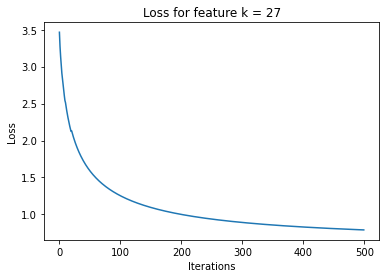

Training Miclassification error is  0.3050732807215333
Test Miclassification error is  0.3245


 Routine Running for k =  36
0 3.465735902800106
1 3.2708274273758793
2 3.1036070819164663
3 2.9593394370112143
4 2.8339991997459832
5 2.7242771053815185
6 2.627497433068785
7 2.541509831468077
8 2.4645857731552363
9 2.395330484413492
10 2.332611991975704
11 2.2755054051918058
12 2.2232496398039747
13 2.175213905994385
14 2.130871719368914
15 2.0897806651479662
16 2.0515665563340706
17 2.0159109550285095
18 1.982541278690978
19 1.9512229038309812
20 1.921752822373124
21 1.8939545125478698
22 1.8676737658586648
23 1.8427752714482326
24 1.8191398042119578
25 1.7966618970986528
26 1.7752479039985882
27 1.7548143795009155
28 1.7352867171195938
29 1.7165979994572829
30 1.6986880230288242
31 1.6815024677184296
32 1.6649921865616693
33 1.649112596073893
34 1.6338231509558407
35 1.6190868898968738
36 1.6048700415214145
37 1.5911416814032227
38 1.5778734325988404
39 1.565039203395673
40 1.55261495699

359 0.8078936842249519
360 0.8073772517791749
361 0.8068632527187998
362 0.8063516698704288
363 0.8058424862228781
364 0.8053356849252655
365 0.8048312492851093
366 0.8043291627664592
367 0.8038294089880424
368 0.8033319717214499
369 0.802836834889339
370 0.8023439825636736
371 0.8018533989639681
372 0.8013650684555768
373 0.8008789755480016
374 0.8003951048932108
375 0.799913441284007
376 0.7994339696523853
377 0.7989566750679472
378 0.798481542736317
379 0.7980085579975764
380 0.7975377063247355
381 0.79706897332223
382 0.7966023447243927
383 0.7961378063940215
384 0.7956753443209035
385 0.7952149446203738
386 0.794756593531925
387 0.7943002774178025
388 0.7938459827616182
389 0.7933936961670172
390 0.7929434043563083
391 0.7924950941691743
392 0.7920487525613518
393 0.7916043666033392
394 0.7911619234791533
395 0.790721410485058
396 0.7902828150283325
397 0.7898461246260574
398 0.789411326903914
399 0.7889784095949859
400 0.7885473605386136
401 0.7881181676792084
402 0.7876908190651

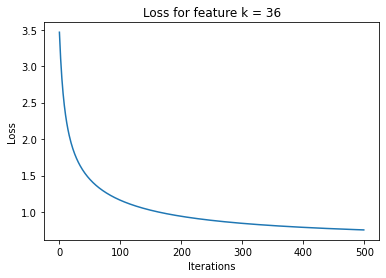

Training Miclassification error is  0.30529875986471255
Test Miclassification error is  0.32499999999999996
[0.7648252536640361, 0.762119503945885, 0.3645997745208568, 0.3050732807215333, 0.30529875986471255] [0.7655000000000001, 0.76, 0.39049999999999996, 0.3245, 0.32499999999999996]


In [66]:
Training_error_vapnik = []
Test_error_vapnik = []
k_list = [5,9,18,27,36]
lr_list = [40,40,35,25,25]
for index,k in enumerate(k_list):
    lr,N_iter,loss_function=lr_list[index],500,'VAPNIK'
    l1,l2 = run_main(k,lr,N_iter,loss_function)
    Training_error_vapnik.append(l1)
    Test_error_vapnik.append(l2)
print(Training_error_vapnik,Test_error_vapnik)

Text(0.5, 1.0, 'For vapnik loss')

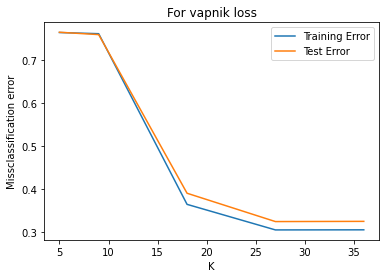

In [67]:
plt.plot(k_list,Training_error_vapnik,label="Training Error")
plt.plot(k_list,Test_error_vapnik,label="Test Error")
plt.legend()
plt.xlabel("K")
plt.ylabel("Missclassification error")
plt.title("For vapnik loss")

# Part 2



 Routine Running for k =  5
0 1.7917594692280547
1 1.7299887256851643
2 1.7021352758537802
3 1.6847668466525259
4 1.6770967841761633
5 1.666796397399072
6 1.6529883210590588
7 1.6562663418064762
8 1.6529445080660323
9 1.6379464189662736
10 1.6402244623977102
11 1.6461649995058498
12 1.6354965475187275
13 1.625200408697309
14 1.6389963162781347
15 1.6309834862274497
16 1.6232749689080483
17 1.6340219401214422
18 1.6271537067691624
19 1.6205148076757028
20 1.6140957229048767
21 1.607887376542894
22 1.6018811174406618
23 1.6182924814432016
24 1.61284858821903
25 1.6075609106482724
26 1.6024238535700839
27 1.597432050897144
28 1.592580356409704
29 1.587863834747813
30 1.5832777526251927
31 1.5788175702843668
32 1.574478933208034
33 1.596861684929634
34 1.5927662339114312
35 1.5887685445666269
36 1.584865695074002
37 1.5810548652254581
38 1.57733333273851
39 1.5736984696687477
40 1.5701477389253482
41 1.5666786908912533
42 1.5632889601493982
43 1.5599762623154438
44 1.556738390976923
45 1

364 1.3848518169353967
365 1.384762269424139
366 1.3846733123532204
367 1.3845849407886028
368 1.3844971498492473
369 1.3844099347063898
370 1.3843232905828697
371 1.3842372127523994
372 1.3841516965389231
373 1.384066737315894
374 1.3839823305057048
375 1.383898471578952
376 1.3838151560538465
377 1.3837323794955712
378 1.3836501375156605
379 1.3835684257714218
380 1.3834872399652922
381 1.383406575844278
382 1.3833264291993759
383 1.3832467958649857
384 1.3831676717183734
385 1.3830890526790824
386 1.3830109347084454
387 1.382933313808965
388 1.382856186023867
389 1.382779547436547
390 1.3827033941700388
391 1.3826277223865577
392 1.382552528286946
393 1.3824778081102536
394 1.3824035581331635
395 1.3823297746696366
396 1.382256454070347
397 1.3821835927222437
398 1.3821111870481284
399 1.3820392335061906
400 1.3819677285895697
401 1.3818966688259056
402 1.3818260507769453
403 1.3817558710380986
404 1.3816861262380324
405 1.3816168130382498
406 1.3815479281327048
407 1.38147946824742

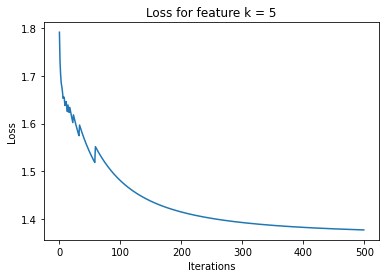

Training Miclassification error is  0.7664036076662909
Test Miclassification error is  0.7655000000000001


 Routine Running for k =  9
0 1.7917594692280547
1 1.7299887256851643
2 1.698950185265442
3 1.6802622612727391
4 1.658194108537355
5 1.644395306898865
6 1.6350126146039285
7 1.6219960576465438
8 1.6140991622905843
9 1.5952394954130789
10 1.5928536391730057
11 1.5764213538503966
12 1.5790126358009056
13 1.5647424474416178
14 1.550960130841995
15 1.5604898423044722
16 1.5485900217339637
17 1.5370691873873974
18 1.5259108003820154
19 1.5150990869344203
20 1.5342265093741954
21 1.5250531930850513
22 1.5161520141628722
23 1.507511213550132
24 1.4991196336916017
25 1.4909666913233353
26 1.4830423501041328
27 1.4753370934047492
28 1.4678418975159861
29 1.5025502126815782
30 1.4964623207540728
31 1.4905418070059127
32 1.4847817922420141
33 1.4791757449784864
34 1.4737174618489919
35 1.4684010490502626
36 1.4632209048068934
37 1.458171702827047
38 1.4532483767150945
39 1.4484461053026798


361 1.3423939258879276
362 1.3423409416103826
363 1.3422883355758592
364 1.3422361045146944
365 1.3421842451915147
366 1.342132754404771
367 1.3420816289862942
368 1.3420308658009144
369 1.3419804617460032
370 1.3419304137510963
371 1.3418807187774686
372 1.3418313738177667
373 1.341782375895565
374 1.3417337220650454
375 1.3416854094105624
376 1.3416374350462945
377 1.341589796115891
378 1.3415424897920725
379 1.3414955132763065
380 1.3414488637984248
381 1.3414025386163146
382 1.3413565350155365
383 1.3413108503090188
384 1.3412654818367034
385 1.341220426965232
386 1.3411756830876154
387 1.3411312476229433
388 1.3410871180160204
389 1.3410432917370763
390 1.3409997662815176
391 1.3409565391695302
392 1.3409136079458608
393 1.3408709701794927
394 1.340828623463355
395 1.3407865654140652
396 1.3407447936716266
397 1.340703305899145
398 1.340662099782613
399 1.34062117303054
400 1.3405805233738
401 1.3405401485653075
402 1.3405000463797594
403 1.340460214613408
404 1.340420651083811
40

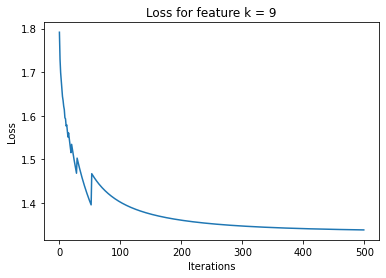

Training Miclassification error is  0.7627959413754228
Test Miclassification error is  0.763


 Routine Running for k =  18
0 1.7917594692280547
1 1.7605656798526241
2 1.7408721932610132
3 1.723864409792755
4 1.7055440404439386
5 1.6940711080442203
6 1.6805070554532209
7 1.6634787494954395
8 1.652795386720595
9 1.6372091198055874
10 1.6290051597047184
11 1.6147017583685277
12 1.6007490679702856
13 1.596134395479586
14 1.5833267581102668
15 1.5708236716924888
16 1.5586178439669554
17 1.5467019729577198
18 1.5350687688333435
19 1.5237109743898205
20 1.5248934539856132
21 1.514410351068437
22 1.504166794414796
23 1.4941565193598767
24 1.4843733577354952
25 1.4748112463203897
26 1.4654642340577722
27 1.456326488101358
28 1.4473922987607024
29 1.4386560834230233
30 1.4301123895325027
31 1.4217558967098856
32 1.4135814180948458
33 1.405583900992167
34 1.397758426899528
35 1.3901002109914713
36 1.3826046011290773
37 1.3752670764607104
38 1.3882817507528047
39 1.3814525111440208
40 1.374764559

360 0.9064621700705703
361 0.9061032244814323
362 0.9057457291810913
363 0.905389674326648
364 0.9050350501705896
365 0.9046818470595669
366 0.9043300554332359
367 0.9039796658230759
368 0.9036306688512358
369 0.9032830552293929
370 0.9029368157576606
371 0.9025919413234569
372 0.9022484229004493
373 0.9019062515474767
374 0.9015654184074975
375 0.9012259147065629
376 0.9008877317527901
377 0.9005508609353664
378 0.900215293723566
379 0.8998810216657575
380 0.8995480363884696
381 0.8992163295954363
382 0.8988858930666614
383 0.8985567186575015
384 0.8982287982977906
385 0.8979021239909167
386 0.8975766878129555
387 0.897252481911823
388 0.896929498506406
389 0.8966077298857354
390 0.8962871684081524
391 0.8959678065005016
392 0.8956496366573219
393 0.89533265144007
394 0.8950168434763174
395 0.8947022054590109
396 0.8943887301456932
397 0.8940764103577754
398 0.8937652389797794
399 0.8934552089586332
400 0.8931463133029519
401 0.8928385450823222
402 0.8925318974266293
403 0.89222636352

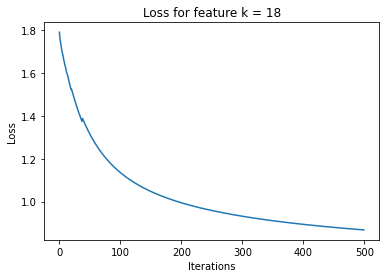

Training Miclassification error is  0.5249154453213078
Test Miclassification error is  0.5425


 Routine Running for k =  27
0 1.7917594692280547
1 1.7694161983655943
2 1.751504905659218
3 1.735668749493874
4 1.7178168789361727
5 1.7032916570596266
6 1.690091217098107
7 1.6744035568035969
8 1.65907101420781
9 1.6440874523255962
10 1.6347395366649666
11 1.620820203133388
12 1.6072119481266778
13 1.5939087298470818
14 1.5809044118221856
15 1.5681927795964916
16 1.5557675576786116
17 1.5436224265134038
18 1.5317510392627787
19 1.5201470381973359
20 1.517924116857996
21 1.5070635220599116
22 1.4964391091832971
23 1.4860451211517474
24 1.475875847701779
25 1.4659256361398227
26 1.4561889011346318
27 1.4466601335292353
28 1.437333908174042
29 1.4282048907968272
30 1.4192678439374957
31 1.4105176319858608
32 1.4019492253678334
33 1.393557703931714
34 1.3853382595896726
35 1.3772861982721802
36 1.3693969412539608
37 1.3616660259095204
38 1.3540891059556557
39 1.3466619512359044
40 1.3393804470

359 0.7457278838920384
360 0.7451668713546962
361 0.744608148287867
362 0.7440517006818629
363 0.7434975146436406
364 0.7429455763955275
365 0.74239587227399
366 0.7418483887284077
367 0.7413031123198622
368 0.7407600297199418
369 0.7402191277095779
370 0.7396803931778664
371 0.7391438131209364
372 0.7386093746408365
373 0.7380770649443839
374 0.7375468713420852
375 0.7370187812470658
376 0.736492782173963
377 0.7359688617379079
378 0.7354470076534638
379 0.7349272077335949
380 0.7344094498886544
381 0.7338937221253841
382 0.733380012545932
383 0.7328683093468551
384 0.7323586008181738
385 0.7318508753424138
386 0.7313451213936707
387 0.7308413275366682
388 0.7303394824258649
389 0.7298395748045293
390 0.7293415935038574
391 0.7288455274420931
392 0.7283513656236508
393 0.7278590971382536
394 0.7273687111601018
395 0.7268801969470079
396 0.7263935438395983
397 0.7259087412604682
398 0.7254257787134001
399 0.7249446457825305
400 0.724465332131607
401 0.7239878275031734
402 0.72351212171

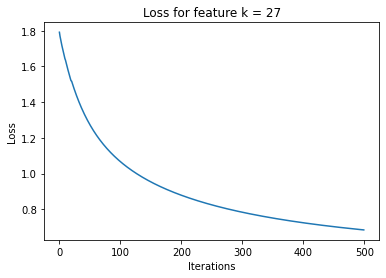

Training Miclassification error is  0.3213077790304397
Test Miclassification error is  0.3365


 Routine Running for k =  36
0 1.7917594692280547
1 1.7694161983655943
2 1.7476795030416303
3 1.7265386242430019
4 1.7059824290024208
5 1.68599942444837
6 1.6665777768752918
7 1.6477053357760834
8 1.629369662590667
9 1.6115580637487084
10 1.5942576274312252
11 1.5774552633528618
12 1.5611377447794712
13 1.5452917519475795
14 1.5299039160422185
15 1.5149608629157514
16 1.50044925578691
17 1.4863558362415878
18 1.4726674629554746
19 1.4593711476694455
20 1.4464540880619792
21 1.4339036972751957
22 1.4217076299561373
23 1.4098538047700824
24 1.3983304234250795
25 1.3871259863155854
26 1.3762293049476244
27 1.3656295113493129
28 1.3553160646986142
29 1.3452787554184846
30 1.335507706996651
31 1.3259933757881446
32 1.3167265490521913
33 1.3076983414642693
34 1.2989001903298896
35 1.2903238497101348
36 1.2819613836510246
37 1.2738051586904227
38 1.2658478357980616
39 1.2580823618861832
40 1.250501

358 0.6961171737262354
359 0.6956237632738803
360 0.6951323830316378
361 0.6946430200507823
362 0.6941556614974781
363 0.6936702946515131
364 0.6931869069050127
365 0.6927054857611243
366 0.6922260188328354
367 0.6917484938416671
368 0.6912728986165046
369 0.6907992210923763
370 0.6903274493092547
371 0.6898575714109226
372 0.6893895756437814
373 0.6889234503557394
374 0.6884591839950631
375 0.6879967651093002
376 0.6875361823441591
377 0.687077424442444
378 0.6866204802429787
379 0.6861653386795766
380 0.6857119887799796
381 0.685260419664868
382 0.6848106205467983
383 0.6843625807292654
384 0.6839162896056891
385 0.68347173665843
386 0.6830289114578816
387 0.6825878036614784
388 0.6821484030127697
389 0.6817106993405222
390 0.6812746825577972
391 0.6808403426610489
392 0.6804076697292498
393 0.6799766539230054
394 0.6795472854836989
395 0.6791195547326497
396 0.6786934520702463
397 0.6782689679751371
398 0.6778460930034014
399 0.6774248177877503
400 0.6770051330367176
401 0.676587029

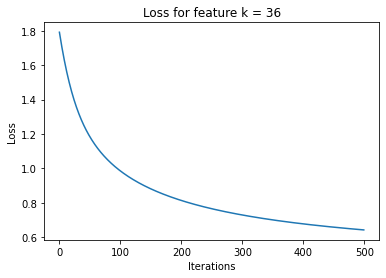

Training Miclassification error is  0.3131905298759865
Test Miclassification error is  0.3295
[0.7664036076662909, 0.7627959413754228, 0.5249154453213078, 0.3213077790304397, 0.3131905298759865] [0.7664036076662909, 0.7627959413754228, 0.5249154453213078, 0.3213077790304397, 0.3131905298759865]


In [43]:
Training_error_entropy = []
Test_error_entropy = []
k_list = [5,9,18,27,36]
lr_list = [70,70,35,25,25]
for index,k in enumerate(k_list):
    lr,N_iter,loss_function=lr_list[index],500,'Cross_Entropy'
    l1,l2 = run_main(k,lr,N_iter,loss_function)
    Training_error_entropy.append(l1)
    Test_error_entropy.append(l2)
print(Training_error_entropy,Test_error_entropy)

Text(0.5, 1.0, 'For Cross Entropy loss')

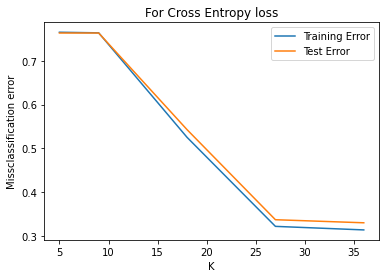

In [41]:
plt.plot(k_list,Training_error_entropy,label="Training Error")
plt.plot(k_list,Test_error_entropy,label="Test Error")
plt.legend()
plt.xlabel("K")
plt.ylabel("Missclassification error")
plt.title("For Cross Entropy loss")